In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import os

# GLOBAL PATH VARIABLE
_path = r'\\emcore.us\dfs\CACON\ATE_Data\SDG500-00100-100' 

Begin with working on a single sample to prove work

In [154]:

file_name = glob.glob(_path + "/J8160-100_ZROTC_SDG500_20210617_215554.csv")
df = pd.read_csv(file_name[0], header=12, usecols=['Time','RateV_Y','TempV_Y'],
 float_precision='high')

In [155]:
# Define parameters
Tmax = 85
Tmin = -40

# Time starts from 0
df['Time'] = df['Time'] - df['Time'][0]

# Temps in V, max and min temps
tempsV = df['TempV_Y']
max_tempV = tempsV.max()
min_tempV = tempsV.min()

#Calculate temperature in Celsius
tmp_sf = (Tmax - Tmin) / (max_tempV - min_tempV)
tmp_bias = Tmax - (tmp_sf * max_tempV)
tempsC = tmp_bias + tmp_sf * tempsV
df['TempC'] = tempsC

In [156]:
# Remove measurements outside middle range 15-40 degrees C

n = len(df)
index_names = df[(df['TempC'] < 15) | (df['TempC'] > 40)].index
df.drop(index_names, inplace=True)

In [157]:
# Drop all values before and after the middle range 15-40C temperature values
# before going from cold to hot
df.drop(range(index_names[-1]+1, n), inplace=True)
df.drop(range(index_names[0]), inplace=True)
df= df.reset_index(drop=True)

In [158]:
# Find ambient point
# Select first measurement that is between 20-25 degrees C

amb_pt = None
for index in range(len(df['TempC'])):
    if 22.51 >= df['TempC'][index] and df['TempC'][index] >= 20:
        amb_pt = index
        break
if not amb_pt:
    print("Error: Ambient Point not found")
print(amb_pt)

32


In [159]:
# Ambient Bias

amb_bias = df['RateV_Y'][amb_pt]

print(amb_bias * 1000)

6.60847


In [160]:
# Max and min deviation

max_rate = df['RateV_Y'].max()
min_rate = df['RateV_Y'].min()

max_dev = max_rate - amb_bias
min_dev = min_rate - amb_bias

# V -> mV
max_dev = max_dev * 1000
min_dev = min_dev * 1000
amb_bias = amb_bias * 1000

print(max_dev)

1.2098230000000005


In [161]:
print(min_dev)

-0.38583500000000015


In [162]:
pk_pk = max_rate - min_rate
# V -> mV
pk_pk = pk_pk * 1000

In [163]:
# Find the coefficients for the line of best fit
m, b = np.polyfit(df['TempC'], df['RateV_Y'], 1)

# Find deviations from the line of best fit
df['Deviation'] = df['RateV_Y']-(m*df['TempC'] + b)

<AxesSubplot:xlabel='TempC'>

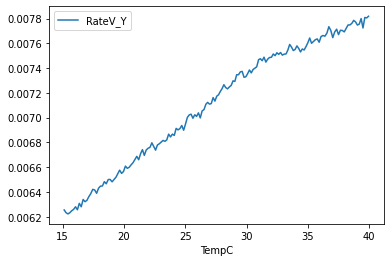

In [164]:
df.plot(x='TempC', y='RateV_Y')

<AxesSubplot:xlabel='TempC'>

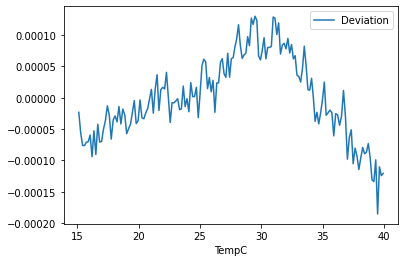

In [165]:
df.plot(x='TempC', y='Deviation')

In [166]:
# Max and min deviations from BFSL represent residual deviations after calibration
cal_max_dev = df['Deviation'].max()
cal_min_dev = df['Deviation'].min()

print(cal_max_dev * 1000)

0.12978400466747386


In [167]:
print(cal_min_dev * 1000)

-0.18519537741868397


Pack it all together in a function, called for each file

In [168]:
# Create a function that performs analytics with the file name and returns list of values
def analytics(file_name):    
    # Find UnitSN and Test Date for the unit
    with open(file_name) as csvfile:
        csvReader = csv.reader(csvfile, delimiter=',')
        for row in csvReader:
            if row[0] == 'UnitSN':
                tag_id = row[1]
                if any(result['Tag Id'] == tag_id):
                    return False
            elif row[0] == 'Model' or row[0] == 'Test Step':
                continue
            elif row[0] == 'Test Date':
                test_date = row[1]
            else:
                break            
                
    df = pd.read_csv(file_name, header=12, usecols=['Time','RateV_Y','TempV_Y'], float_precision='high')
    
    # Define parameters
    Tmax = 85
    Tmin = -40    
    # Time starts from 0
    df['Time'] = df['Time'] - df['Time'][0]
    # Temps in V, max and min temps
    tempsV = df['TempV_Y']
    max_tempV = tempsV.max()
    min_tempV = tempsV.min()
    # Calculate temperature in Celsius
    tmp_sf = (Tmax - Tmin) / (max_tempV - min_tempV)
    tmp_bias = Tmax - (tmp_sf * max_tempV)
    tempsC = tmp_bias + tmp_sf * tempsV
    df['TempC'] = tempsC
    
    # Drop all values before and after the middle range 15-40C temperature values
    n = len(df)
    index_names = df[(df['TempC'] < 15) | (df['TempC'] > 40)].index
    df.drop(index_names, inplace=True)
    df.drop(range(index_names[-1]+1, n), inplace=True)
    df.drop(range(index_names[0]), inplace=True)
    df= df.reset_index(drop=True)
    
    # Find ambient point
    # Select first measurement that is between 20-25 degrees C
    amb_pt = None
    for index, row in df.iterrows():
        if 25 >= row['TempC'] and row['TempC'] >= 20:
            amb_pt = index
            break
    if not amb_pt:
        print("Error: Ambient Point not found")
        return None
    
    # Ambient Bias
    amb_bias = df['RateV_Y'][amb_pt]

    # Max and min deviation
    max_rate = df['RateV_Y'].max()
    min_rate = df['RateV_Y'].min()    
    max_dev = max_rate - amb_bias
    min_dev = min_rate - amb_bias
    
    # V -> mV
    amb_bias = amb_bias * 1000
    max_dev = max_dev * 1000
    min_dev = min_dev * 1000

    pk_pk = max_rate - min_rate
    
    # V -> mV
    pk_pk = pk_pk * 1000
    
    # Find the coefficients for the line of best fit
    m, b = np.polyfit(df['TempC'], df['RateV_Y'], 1)

    # Find deviations from the line of best fit
    df['Deviation'] = df['RateV_Y']-(m*df['TempC'] + b)
    
    # Max and min deviations from BFSL represent residual deviations after calibration
    cal_max_dev = df['Deviation'].max()
    cal_min_dev = df['Deviation'].min()

    # V -> mV
    cal_max_dev = cal_max_dev * 1000
    cal_min_dev = cal_min_dev * 1000
    
    return { 
        'Tag Id': tag_id,
        'Test Date': test_date,
        'Ambient Bias mVdc': amb_bias,
        'Max Deviation from Amb mVdc': max_dev,
        'Min Deviation from Amb mVdc': min_dev,
        'Pk-Pk mVdc': pk_pk,
        'Max Deviation after Calibration': cal_max_dev,
        'Min Deviation after Calibration': cal_min_dev,
        'Meets -105 temp spec': (abs(max_dev) <= 2) & (abs(min_dev) <= 2),
        'Meets -106 temp spec': (abs(max_dev) <= 0.5) & (abs(min_dev) <= 0.5),
        '-105 Post-Calibration meets temp spec': (abs(cal_max_dev) <= 2) & (abs(cal_min_dev) <= 2),
        '-106 Post-Calibration meets temp spec': (abs(cal_max_dev) <= 0.5) & (abs(cal_min_dev) <= 0.5)        
    }


In [169]:
# Test result dataframe schema
d = {
    'Tag Id':[],
    'Test Date':[],
    'Ambient Bias mVdc':[],
    'Max Deviation from Amb mVdc':[],
    'Min Deviation from Amb mVdc':[],
    'Pk-Pk mVdc':[],
    'Max Deviation after Calibration': [],
    'Min Deviation after Calibration': [],
    'Meets -105 temp spec': [],
    'Meets -106 temp spec': [],
    '-105 Post-Calibration meets temp spec': [],
    '-106 Post-Calibration meets temp spec': []    
}

# Totals by month dataframe
totals = pd.DataFrame(columns=[
    'Month',
    'Total',
    '105 Count',
    '106 Count',
    '105 Yield',
    '106 Yield',
    '105 Count Calibrated',
    '106 Count Calibrated',
    '105 Yield Calibrated',
    '106 Yield Calibrated'
])

# Initialize dataframe of all test results
result = pd.DataFrame(data=d)

Loop through each file, perform analytics, output to csv

In [182]:
# Perform analysis month by month, simultaneously append test results to table for the year

months = ['202107','202106','202105', '202104', '202103', '202102', '202101', '202012', '202011', '202010',
          '202009', '202008', '202007', '202006', '202005', '202004', '202003', '202002', '202001']


for month in months:
    file_names = sorted(glob.glob(_path + "/*-100_ZROTC_SDG500*_" + month + "*.csv"), key = os.path.getmtime, reverse=True)
    # Reset dataframe holding results for the month
    month_result = pd.DataFrame(data=d)

    # Loop through each file name
    for file_name in file_names:
        unit = analytics(file_name)
        if unit:
            month_result = month_result.append(unit, ignore_index=True)
            # Append result to df of test results for year
            result = result.append(unit, ignore_index=True)
            
    # Calculate totals for each month
    
    count_105 = month_result['Meets -105 temp spec'].sum()
    count_106 = month_result['Meets -106 temp spec'].sum()
    count_105_cal = month_result['-105 Post-Calibration meets temp spec'].sum()
    count_106_cal = month_result['-106 Post-Calibration meets temp spec'].sum()
    
    total = len(month_result)
    
    yield_105 = count_105/total
    yield_106 = count_106/total
    yield_105_cal = count_105_cal/total
    yield_106_cal = count_106_cal/total
    
    month_data = {
        'Month': month,
        'Total': total,
        '105 Count': count_105,
        '106 Count': count_106,
        '105 Yield': yield_105*100,
        '106 Yield': yield_106*100,
        '105 Count Calibrated': count_105_cal,
        '106 Count Calibrated': count_106_cal,
        '105 Yield Calibrated': yield_105_cal*100,
        '106 Yield Calibrated': yield_106_cal*100,
    }
    
    totals = totals.append(month_data, ignore_index=True)

# totals.to_csv("By_Month_SDG500-00100_Ambient_Temperature_Test_Results.csv")    

In [183]:
count_105 = result['Meets -105 temp spec'].sum()
count_106 = result['Meets -106 temp spec'].sum()
count_105_cal = result['-105 Post-Calibration meets temp spec'].sum()
count_106_cal = result['-106 Post-Calibration meets temp spec'].sum()

print(count_105)

596.0


In [184]:
print(count_106)

169.0


In [185]:
print(count_105_cal)

1945.0


In [186]:
print(count_106_cal)

1905.0


In [187]:
total = len(result)
print(total)

1948


In [176]:
# Yields
yield_105 = count_105/total
yield_106 = count_106/total
yield_105_cal = count_105_cal/total
yield_106_cal = count_106_cal/total

print(yield_105)

0.30167890870933894


In [177]:
print(yield_106)

0.0844700944386149


In [178]:
print(yield_105_cal)

0.9984260230849947


In [179]:
print(yield_106_cal)

0.9774396642182581


In [180]:
# Output results to a csv
totals.to_csv("Monthly_Totals_SDG500-00100_2020-2021_Ambient_Temperature_Test_Results.csv")
result.to_csv("Year_SDG500-00100_2020-2021_Ambient_Temperature_Test_Results.csv")

In [181]:
print(result)

     Tag Id               Test Date  Ambient Bias mVdc  \
0     J8300  06/30/2021 08:12:25 PM          11.094200   
1     J8283  06/30/2021 09:23:10 AM           8.805082   
2     J8312  06/30/2021 09:23:10 AM          -0.929563   
3     J8314  06/30/2021 09:23:10 AM           4.525005   
4     J8315  06/29/2021 08:37:53 AM           5.048823   
...     ...                     ...                ...   
1901  J3259  01/02/2020 08:00:28 PM           3.991447   
1902  J3163  01/02/2020 08:00:28 PM           2.966646   
1903  J2991  01/02/2020 07:20:05 PM          -1.606977   
1904  J3188  01/02/2020 07:20:05 PM          -0.346269   
1905  J3260  01/02/2020 07:20:05 PM           0.354280   

      Max Deviation from Amb mVdc  Min Deviation from Amb mVdc  Pk-Pk mVdc  \
0                        0.554490                    -2.273658    2.828148   
1                        1.094112                    -5.139330    6.233442   
2                       23.005573                    -5.993167   28.9